In [25]:
import pickle
import os
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt

path = '/nobackup/jakravit/data/HE60/output/EcoLight/excel/'
dirlist = os.listdir(path)

print(dirlist)

['MI_case1V3_mvil2cizg6.txt', '.ipynb_checkpoints', 'MI_case1V3_1ncx3oig93.txt', 'MI_case1V3_76283yxqwh.txt', 'MI_case1V3_a1nlo8ttef.txt', 'MI_case1V3_osptqhlu1t.txt']


In [49]:
outFile = path + 'MI_case1V3_osptqhlu1t.txt'
uid = 'osptqhlu1t'
bname = '/nobackup/jakravit/data/HE60/batch_data/case1V3_inputs.csv'

rrsheader = ['in air', 'Rrs']

line_num = 0
with open(outFile, 'r') as f:
    lines = f.readlines()

for line in lines:
    line_num += 1
    if all(x in line.strip().replace('"', '').replace("'", "") for x in rrsheader):
        header = line_num
        l = line
        # print (line_num, line)
    else:
        pass

lines = np.arange(header,header+201,1)
end = header+201
rrs = []
lw = []
ed = []
wl = []
lu = []

i = 0
with open(outFile, "r+") as fp:
    # access each line
    while True:
        line = fp.readline()
        # check line number
        if i in lines:
            wl.append(line.strip().split('   ')[0] )
            rrs.append(line.strip().split('   ')[1] )
            ed.append(line.strip().split('   ')[2] )
            lw.append(line.strip().split('   ')[3])
            lu.append(line.strip().split('   ')[4] )
        # line number greater than needed exit the loop
        # lines[-1] give last item from list
        if i > end:
            break;
        i = i + 1

wl = np.array(wl).astype(float)
rrs = np.array(rrs).astype(float)
lw = np.array(lw).astype(float)
lu = np.array(lu).astype(float)
ed = np.array(ed).astype(float)
lg = lu-lw
rrsg = lg / ed
rrsgmean = rrsg.mean()
rrstot = lu / ed

In [50]:
kparheadlist = ['depth', 'K_PAR (from Eo)', 'K_d (broadband)']
parheadlist = ['depth', 'PAR_Eo', 'PAR_Ed']
bheadlist = ['scat coef b']
aheadlist = ['abs coef a']

line_num = 0
with open(outFile, 'r') as f:
    lines = f.readlines()

for line in lines:
    line_num += 1
    if all(x in line.strip().replace('"', '').replace("'", "") for x in kparheadlist):
        kparheader = line_num
        l1 = line

    elif all(x in line.strip().replace('"', '').replace("'", "") for x in parheadlist):
        parheader = line_num 
        l2 = line

    elif all(x in line.strip().replace('"', '').replace("'", "") for x in bheadlist):
        bheader = line_num 
        l3 = line

    elif all(x in line.strip().replace('"', '').replace("'", "") for x in aheadlist):
        aheader = line_num
        l4 = line

    else:
        pass  

In [51]:
# lines = np.arange(header,header+201,1)
# end = header+201

kparline = kparheader
parline = parheader + 1
blines = np.arange(bheader+2, bheader+203, 1)
alines = np.arange(aheader+2, aheader+203, 1)
end = aheader+203

kpar = []
par = []
b = []
a = []

i = 0
with open(outFile, "r+") as fp:
    # access each line
    while True:
        line = fp.readline()
        
        # check line number
        if i == kparline:
            kpar.append(line.strip().split('   ')[1])
        elif i == parline:
            par.append(line.strip().split('   ')[1])
        elif i in blines:
            b.append(line.strip().split('   ')[1] )
        elif i in alines:
            a.append(line.strip().split('   ')[1] )
        
        if i > end:
            break;
        i = i + 1

kpar = float(kpar[0])
par = float(par[0])
a = np.array(a).astype(float)
b = np.array(b).astype(float)
c = a + b
ctot685 = c[114] # 685 nm 
ctot740 = c[136] # 740 nm 


In [56]:
print (ctot685)

0.480064


In [52]:
bdata = pd.read_csv(bname,index_col=0)
aphyEuk = bdata.filter(regex='^aphyEuk')
aphyCy = bdata.filter(regex='^aphyCy')
fqy = bdata.loc[uid,'FQY']
# qa = bdata.loc[uid,'Qa']
qa = np.random.choice([.3,.4,.5,.6])

In [53]:
aphyEukSim = aphyEuk.loc[uid,:]
aphyEukPar = aphyEukSim[:121].values

aphyCySim = aphyCy.loc[uid,:]
aphyCyPar = aphyCySim[:121].values

lpar = np.arange(400, 702.5, 2.5)
ps = np.random.choice(np.arange(.1,.21, .01))
absdphy = integrate.simps(aphyEukPar, lpar) * par + \
        ((integrate.simps(aphyCyPar, lpar) * ps) * par)

ktot_g1 = kpar + ctot685
ktot_g2 = kpar + ctot740
    
absd_g1 = absdphy / ktot_g1
absd_g2 = absdphy / ktot_g2

lf_g1 = (.54 * (1 / (4 * np.pi)) * (fqy/25) * qa) * absd_g1
lf_g2 = (.54 * (1 / (4 * np.pi)) * (fqy/50) * qa) * absd_g2

flamp_g1 = (lf_g1 / 1.23) * .001
flamp_g2 = (lf_g2 / 1.23) * .001

In [54]:
def normal_dist(x , amp, mean , sd):
    prob_density = amp * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

pdf = normal_dist(wl, flamp_g1, 685, 25/2.355) + normal_dist(wl, flamp_g2, 740, 50/2.355)


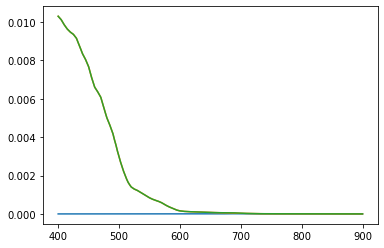

In [55]:
fig, ax = plt.subplots()
ax.plot(wl,pdf, label='fl')
ax.plot(wl,rrs, label='rrs')
ax.plot(wl,rrs+pdf, label= 'rrstot')